### Imports 

In [24]:
%matplotlib inline
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import vgg16
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools

### Load & Prep Data

In [15]:
train_path  = './DATA/SIGN_LANGUAGE/train'
validation_path  = './DATA/SIGN_LANGUAGE/validation'
test_path  = './DATA/SIGN_LANGUAGE/test'

#### Explore Data

In [16]:
img = mpimg.imread(f'{train_path}/0/IMG_1118.JPG')

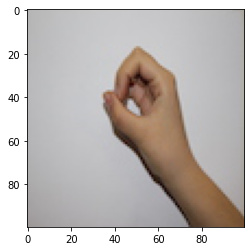

In [17]:
plt.imshow(img)

In [18]:
img.shape

(100, 100, 3)

<p>ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
The data will be looped over (in batches).<br>
    <b>Note:</b> In this example, we won't be doing any image augmentation.</p>

In [19]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224, 224), 
                                                         batch_size=10)

Found 1712 images belonging to 10 classes.


In [20]:
train_batches.next()[0][0].shape

(224, 224, 3)

#### Visualize Random Sample of Images from Train Batch

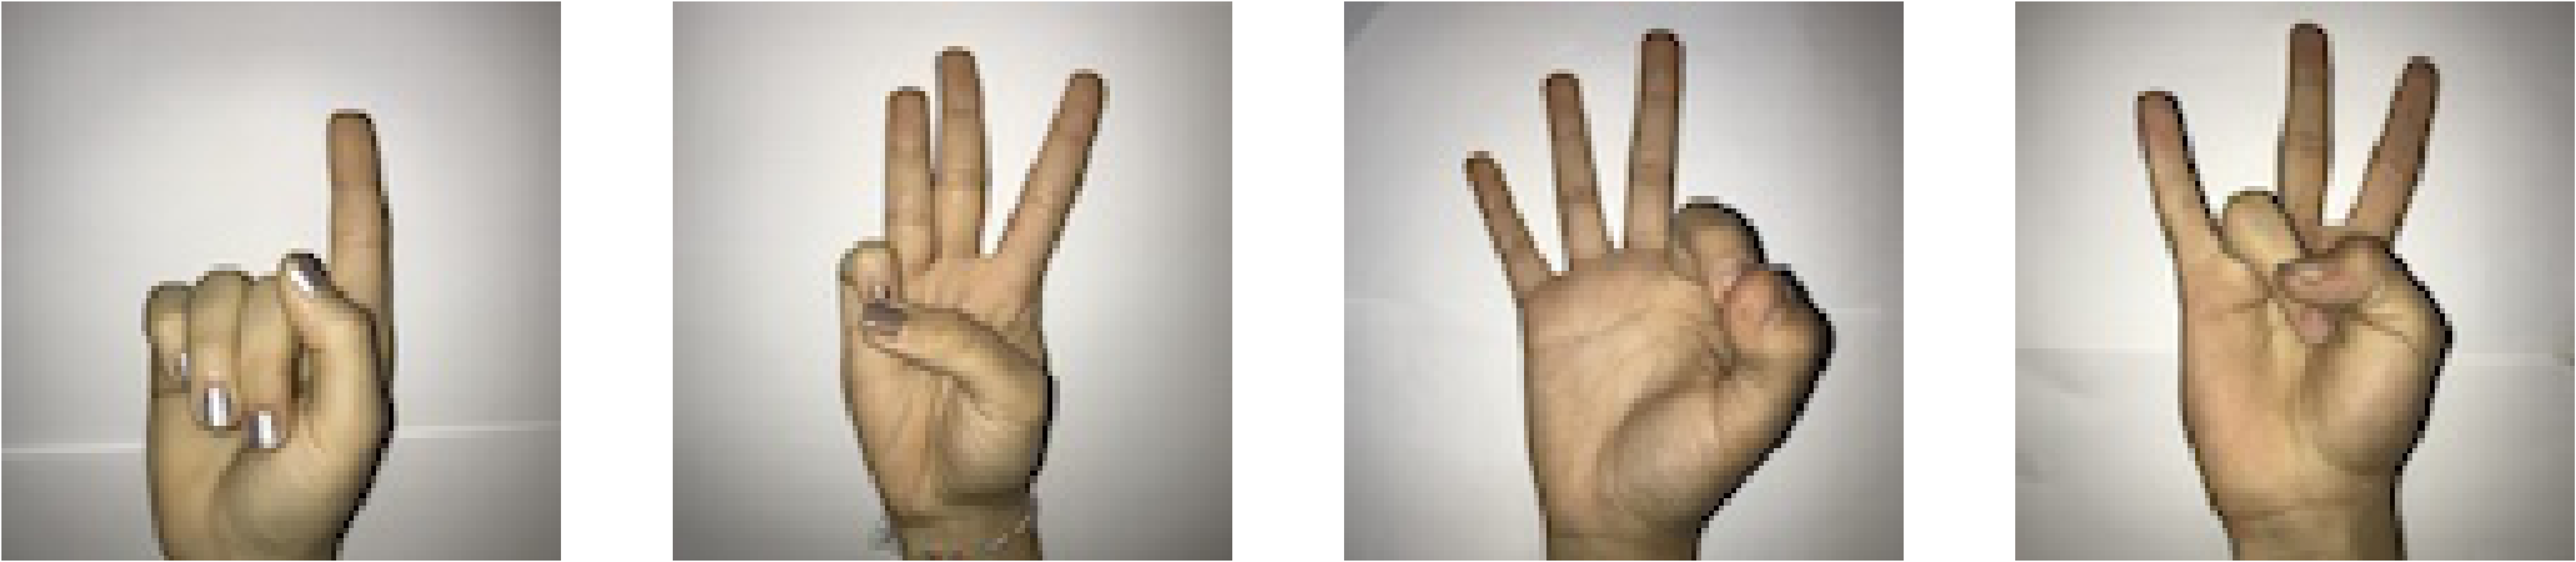

In [21]:
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(224, 224))
for row in rows:
    row.imshow(train_batches.next()[0][0].astype('int'))
    row.axis('off')
plt.show()

In [ ]:
validation_batches = ImageDataGenerator().flow_from_directory(validation_path,
                                                         target_size=(224,224), 
                                                         batch_size=30)

In [ ]:
test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224), 
                                                        batch_size=50, 
                                                        shuffle=False)

### Load Base Model
#### VGG16 CNN Model pre-trained on ImageNet dataset

In [ ]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

### Freeze the Classification Layers in Base Model

In [ ]:
for layer in base_model.layers[:-5]:
    layer.trainable = False

base_model.summary()

### Define New Model

In [ ]:
# get last layer of the network
last_layer = base_model.get_layer('global_average_pooling2d')

# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

# add our new softmax layer with 3 hidden units
x = Dense(10, activation='softmax', name='softmax')(last_output)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model.summary()

### Compile the New Model

In [ ]:
new_model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

### Train the New Model

In [ ]:
checkpointer = ModelCheckpoint(filepath='sign-language.model.hdf5', save_best_only=True)

<p><b>Note: </b>Since we have 1,712 images in the training dataset (across all classes) 
and a batch size of 10 assigned, the steps_per_epoch would be about 18, or 1712/10.</p>
<p> We take the ceiling because we do not drop the remainder of the batch.</p>

In [ ]:
history = new_model.fit(train_batches, 
                        steps_per_epoch=18, 
                        validation_data=validation_batches, 
                        validation_steps=3, 
                        epochs=20, 
                        verbose=1, 
                        callbacks=[checkpointer])

### Visualize Training

In [ ]:
def plot_training_history(history):          
    hist = pd.DataFrame(history.history)          
    hist['epoch'] = history.epoch          
    plt.figure()          
    plt.xlabel('Epoch')          
    plt.ylabel('Accuracy')          
    plt.plot(hist['epoch'], hist['accuracy'] * 100, label='Train Accuracy')          
    plt.plot(hist['epoch'], hist['val_accuracy'] * 100, label='Validation Accuracy')
    plt.ylim([0, 100])          
    plt.legend()  
    
    plt.figure()          
    plt.xlabel('Epoch')          
    plt.ylabel('Loss')          
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')          
    plt.plot(hist['epoch'], hist['val_loss'], label='Validation Loss')
    plt.ylim([0,2])
    plt.legend()          
    plt.show()

In [ ]:
plot_training_history(history)

### Evaluate Model

In [41]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
from tensorflow.keras import utils
from tqdm import tqdm
import numpy as np

In [37]:
test_data = load_files('DATA/SIGN_LANGUAGE/test')

In [38]:
test_files = np.array(test_data['filenames'])
test_targets = utils.to_categorical(np.array(test_data['target']))

In [39]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|██████████| 100/100 [00:00<00:00, 361.77it/s]


In [42]:
%%time 

model = load_model('sign-language.model.hdf5')

CPU times: user 551 ms, sys: 288 ms, total: 840 ms
Wall time: 1.35 s


In [45]:
result = model.evaluate(test_tensors, test_targets, verbose=1)
print(f'Test Accuracy: {result[1]}')

4/4 [==============================] - 22s 5s/step - loss: 0.2551 - accuracy: 0.9100
Test accuracy: 0.9100000262260437


#### Create Confusion Matrix 

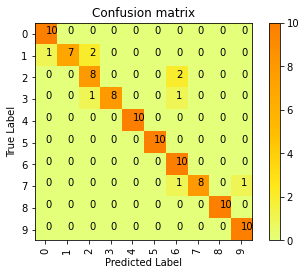

In [51]:
cm_labels = ['0','1','2','3','4','5','6','7','8','9']
cm = confusion_matrix(np.argmax(test_targets, axis=1),
                      np.argmax(model.predict(test_tensors), axis=1))
plt.imshow(cm, cmap=plt.cm.Wistia)
plt.colorbar()
indices = np.arange(len(cm_labels))
for i in indices:
    for j in indices:
        plt.text(j, i, cm[i, j])
plt.xticks(indices, cm_labels, rotation=90)
plt.xlabel('Predicted Label')
plt.yticks(indices, cm_labels)
plt.ylabel('True Label')
plt.title('Confusion matrix')
plt.show()